# Fast Predictions of Roll using Data CFD and Machine Learning

Camilla F.I. Blakesley

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import fsolve, least_squares,curve_fit

from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification


import statistics
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from pathlib import Path

data_folder = Path("Roll-prediction--main1/Roll-prediction--main")

## Geometry

<IPython.core.display.Javascript object>


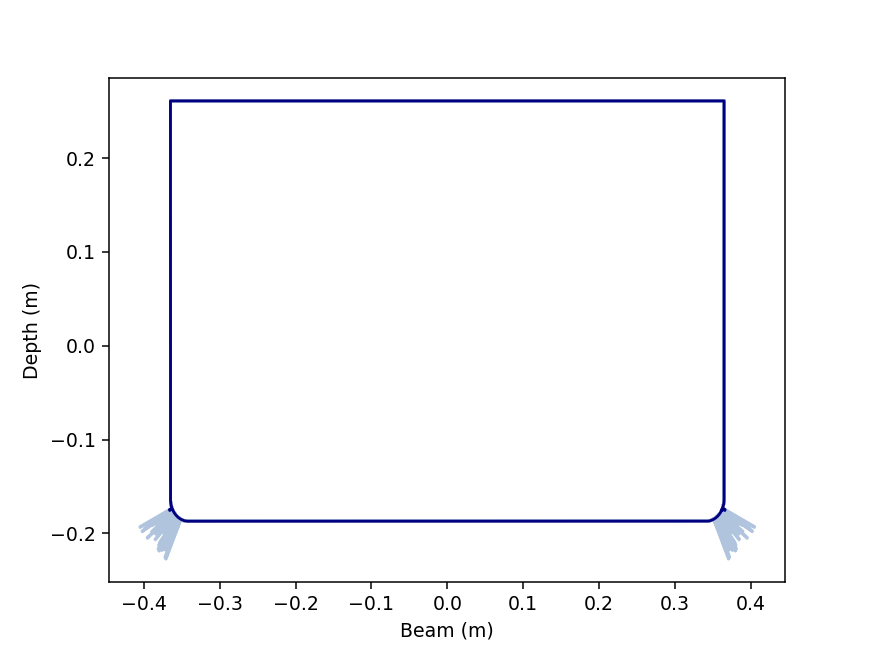

In [3]:
%matplotlib notebook
file_num = np.arange(1,55,1)

for x in file_num:
    data_section = pd.read_pickle(data_folder/'data_MARIN_CFD/extractedGeometries_withFreeSurface/Rolldamping{}/geometry.pkl'.format(x))
    B1 = data_section['x']
    D = data_section['y']
    Bilge_Radius = 0.023375
    L= 0.1                       
    
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    b_bk = 0.001
    l_bk = data_period['KeelLength']
    yOG = data_period['yCG']
    Volume = data_period['displacement']
    Area = Volume/L
    xOG = 0

    Beam = 0.7269
    Draught = 0.1870 
    B_T = Beam/Draught
    Cm = Area/(Beam*Draught)
    
    Cb = Volume/(Beam*Draught*L)
    
    disp = data_period['displacement']
    
   
    plt.plot (B1,D,label='Ship Section',color = 'lightsteelblue')
    plt.xlabel('Beam (m)')
    plt.ylabel('Depth (m)')
    plt.show()

data_section = pd.read_pickle(data_folder/'data_MARIN_CFD/extractedGeometries_withFreeSurface/Rolldamping2/geometry.pkl')
B1 = data_section['x']
D = data_section['y']
plt.plot (B1,D,label='Ship Section', color = 'navy')

## Lewis Section Mapping

In [ ]:
file_num = np.arange(1,55,1)

for i in file_num:
    def func(x):                                                
        return [((2*(1+x[0]+x[1]))/(1-x[0]+x[1]))-B_T,                                                   
                    (((np.pi/2)*(1-(x[0]**2)-(3*((x[1]**2)))))/((2*(1+x[0]+x[1]))*(1-x[0]+x[1])))-Cm] 
    root = fsolve(func, [0, 0]) 
    a1 = root[0]
    a3 = root[1]
    
    theta = np.linspace(0, np.pi, num = 21)
    u= ((1+a1)*np.cos(theta)+a3*np.cos(3*theta))*(Beam/(2*(1+a1+a3)))
    v=-((1-a1)*np.sin(theta)-a3*np.sin(3*theta))*(Draught/((1-a1+a3)))

## CFD Data

### Wave Damping

In [5]:
g = 9.81
rho = 1025

file_num = np.arange(0,305,1)

df_BW = []

for x in file_num:
    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    theta1 = (data_timetrace['rollAngle'])
    theta_rep =(max(theta1))
    
    wave_height= data_timetrace['waveHeight']
    omega= data_timetrace['rollRate']
    time = data_timetrace['t']
    
    dt = time.diff().values[1]
    spectrum0 = np.abs(np.fft.fft(wave_height))
    N = len(spectrum0)
    spectrum = 2 * spectrum0[:round(N/2)] /N
    freq = np.linspace(0.0, 1.0/(2.0*dt), round(N/2))

    theta0 = np.angle(np.fft.fft(wave_height))
    theta = 2 * theta0[:round(N/2)] /N
    
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    T = T_column[x]

    z = spectrum
    peaks, _ = find_peaks(z)
    prominences = peak_prominences(z, peaks)[0]
    contour_heights = z[peaks] - prominences
    peaks_list = sorted(zip(z[peaks]), reverse=True)[:3]

    if peaks_list[0] == 1e-05:
        a_peak1 = max(wave_height)
    else:
        a_peak1 = peaks_list[0]
    
    f_peak1 = freq[spectrum==a_peak1]
    theta_peak1 = theta[freq==f_peak1]
    
    a_peak2 = peaks_list[1]
    f_peak2 = freq[spectrum==a_peak2]
    theta_peak2 = theta[freq==f_peak2]
    
    a_peak3 = peaks_list[2]
    f_peak3 = freq[spectrum==a_peak3]
    theta_peak3 = theta[freq==f_peak3]
    
    total_a = np.asarray(a_peak1)+np.asarray(a_peak2)+np.asarray(a_peak3)
    a_peak_total = max(wave_height)
    
    wave1 = a_peak1*np.sin((f_peak1*2*np.pi*(time-theta_peak1)))
    wave2 = a_peak2*np.sin((f_peak2*2*np.pi*(time-theta_peak2)))
    wave3 = a_peak3*np.sin((f_peak3*2*np.pi*(time-theta_peak3)))
    wave_total = wave1+wave2+wave3
    
    omega_rep = 2*np.pi/T
    F_rep = 1/T

    phase_velocity = g/omega_rep
    group_velocity = 0.5*phase_velocity
    
    E_Bar1 = 0.5*rho*g*np.array(a_peak1)**2
    E_Bar2 = 0.5*rho*g*np.array(a_peak2)**2
    E_Bar3 = 0.5*rho*g*np.array(a_peak3)**2
    
    dE_dt1 =group_velocity*E_Bar1
    dE_dt2 =group_velocity*E_Bar2
    dE_dt3 =group_velocity*E_Bar3

    B_W1 = dE_dt1/omega_rep**2
    B_W2 = dE_dt2/omega_rep**2
    B_W3 = dE_dt3/omega_rep**2
    
    if total_a <= 1e-04:
        E_Bar = 0.5*rho*g*np.array(a_peak_total)**2
        dE_dt = group_velocity*E_Bar
        B_W = dE_dt/omega_rep**2
    else:
        B_W = (B_W1 + B_W2 + B_W3)
    
    numpy_array = [(theta_rep),(omega_rep),B_W]
    df_BW.append(numpy_array)
    
df_BW = pd.DataFrame(df_BW, columns = ('theta','omega','B_W_Energy'))

### Total Damping

In [6]:
file_num = np.arange(0,305,1)

df_Btot = []

for x in file_num:
    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    time = data_timetrace['t']
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    RollDampMom= data_timetrace['Mzz_fitted_damping']
    RollDampMom = max(RollDampMom)
    
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    T = T_column[x]
    omega_rep = 2*np.pi/T

    B_star_tot = RollDampMom/(theta_rep*omega_rep)
    B_tot = B_star_tot/(((3*np.pi)/8))
    
    numpy_array = [(theta_rep),(omega_rep),B_tot]
    df_Btot.append(numpy_array)
    
df_Btot = pd.DataFrame(df_Btot, columns = ('theta','omega','B_total'))

B_tot =np.array(df_Btot['B_total'])


In [7]:
data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv")
theta_rep = (data_period['amplitude'])

B_W_energy1 =np.array(df_BW['B_W_Energy'])
B_W_energy = B_W_energy1 

B_ratio = (B_W_energy/B_tot)*100

<IPython.core.display.Javascript object>


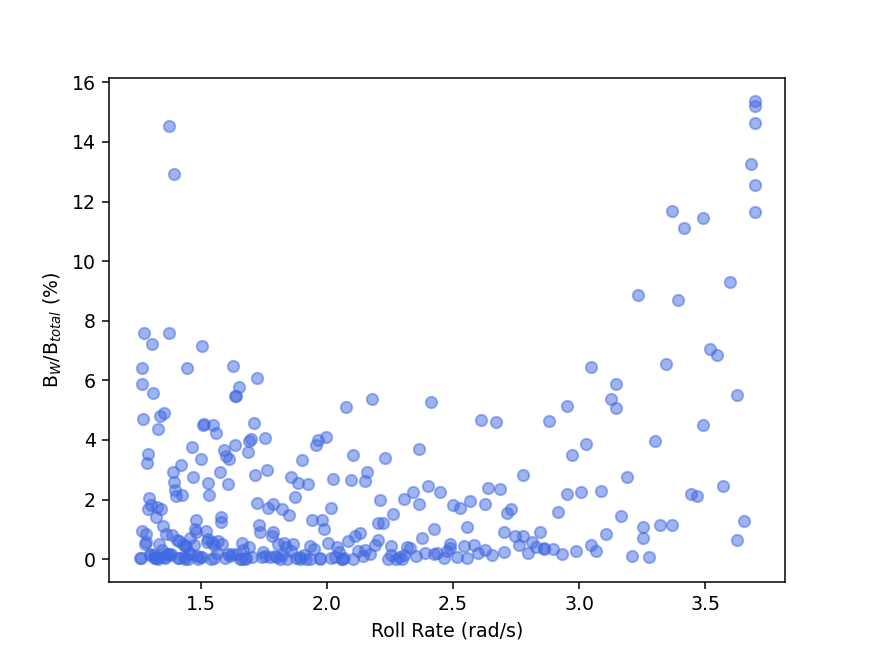

In [8]:
plt.figure()
plt.plot(df_BW['omega'],B_ratio,'o', alpha = 0.5, color= "royalblue")
plt.plot()
plt.xlabel('Roll Rate (rad/s)')
plt.ylabel('B${_W}$/B$_{total}$ (%)')
plt.show()

### Eddy/Bilge Damping

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

file_num = np.arange(0,305,1)

df_BE = []

for x in file_num:
    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    time = data_timetrace['t']
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    RollDampMom= data_timetrace['Mzz_fitted_damping']
    Test_case = data_period['case']
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    keelLength = data_period['KeelLength']
    keelAngle = data_period['KeelAngle']
    CofG = data_period['yCG']
    K_L = keelLength[x]
    K_A = keelAngle[x]
    CoG = CofG[x]
    T = T_column[x]
    omega_rep = 2*np.pi/T

    WaveDampMom = B_W * omega     
    EddyDampMom= RollDampMom-WaveDampMom

    B_2 = EddyDampMom/(omega*abs(omega))
    B_E = abs(B_2*omega*theta_rep)

    numpy_array = ([theta_rep,omega_rep,B_E[x],K_L,K_A,CoG])
    df_BE.append(numpy_array)
    
df_BE = pd.DataFrame(df_BE, columns = ('theta','omega','B_E_CFD','Keel Length','Keel Angle','CoG'))

## Ikeda' Method


### Eddy Damping

In [10]:
r_m = ((2*Area)/np.pi)**0.5
sigma = Area/(Beam*Draught)
f_1 = 0.5*(1+np.tanh(20*(sigma-0.7)))
f_2 = (0.5*(1-np.cos(np.pi*sigma)))-(1.5*(1-(np.exp(-5*(1-sigma))))*((np.sin(np.pi*sigma))**2))

R = Bilge_Radius          
Ho = L/(2*Draught)
phi1 = 0
phi2 = 0.5*(np.arccos((a1*(1+a3))/(4*a3)))

M = Beam/((2)*(1+a1+a3))
M1 = Beam/((2)*(1+a1+a3))

rmax1 = M*(((((1+a1)*np.sin(phi1))-(a3*np.sin(3*phi1))**2)+((((1-a1)*np.cos(phi1))+(a3*np.cos(3*phi1)))**2))**0.5)
rmax2 = M*(((((1+a1)*np.sin(phi2))-(a3*np.sin(3*phi2))**2)+((((1-a1)*np.cos(phi2))+(a3*np.cos(3*phi2)))**2))**0.5)
rmax=max(rmax1,rmax2)
if rmax1 >= rmax2:
    phi = phi1
else:
    phi = phi2
H = 1+(a1**2)+(9*(a3**2))+(2*a1*(1-(3*a3))*np.cos(2*phi))-(6*a3*np.cos(4*phi))
A = (-2*a3*np.cos(5*phi))+(a1*(1-a3)*np.cos(3*phi))+(((6-(3*a1))*(a3**2))+((((a1**2)-(3*a1))*a3)+(a1**2))*np.cos(phi))
B = (-2*a3*np.sin(5*phi))+(a1*(1-a3)*np.sin(3*phi))+(((6+(3*a1))*(a3**2))+((((a1**2)+(3*a1))*a3)+(a1**2))*np.sin(phi))
    
f3 = 1+(4*np.exp(1.65E-05*(1-sigma)**2))
Ho_ = Ho/(1-(yOG/Draught))
sigma_ = (sigma -(yOG/Draught))/(1-(yOG/Draught))
    
gamma = (((np.pi**0.5)*f3)/(2*Draught*(1-(yOG/Draught))*(Ho_*sigma_)))*(rmax+(((2*M)/H)*(((A**2)+(B**2))**0.5)))

C_p =0.5*((0.87*np.exp(-gamma))-(4*np.exp(-0.187*gamma))+3)

In [71]:
file_num = np.arange(0,305,1)

list_theta_rep = []
list_B_E_ikeda = []
list_omega_rep = []

for x in file_num:
    data_timetrace = pd.read_csv(data_folder/'data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv'.format(x))
    T_column = data_period['period']
    T = T_column[x]
    omega_rep = 2*np.pi/T
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    B_E_ikeda = (4/(3*np.pi))*rho*L*(Draught**2)*(r_m**2)*theta_rep*omega_rep*((1-f_1*(R/Draught))*(1-(yOG/Draught)-(f_1*(R/Draught)))+(f_2*((Ho_-(f_1*(R/Draught)))**2)))*C_p
  
    list_theta_rep.append(theta_rep)
    list_B_E_ikeda.append(B_E_ikeda)
    list_omega_rep.append(omega_rep)

In [11]:
file_num = np.arange(0,305,1)

df_BE_ikeda = []
for x in file_num:
      
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    T = T_column[x]

    omega_rep = (2*np.pi/T)
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    
    non_dim_factor = (1/(1025*disp*(Beam**2)))*(3*np.pi)/8
    
    B_E_ikeda = ((4/(3*np.pi))*rho*L*(Draught**2)*(r_m**2)*theta_rep*omega_rep*((1-f_1*(R/Draught))*(1-(yOG/Draught)-(f_1*(R/Draught)))+(f_2*((Ho_-(f_1*(R/Draught)))**2)))*C_p)*non_dim_factor
    
    numpy_array_BE_ikeda = [theta_rep,B_E_ikeda[x]]
    df_BE_ikeda.append(numpy_array_BE_ikeda)
    
df_BE_ikeda = pd.DataFrame(df_BE_ikeda, columns = ('theta','B_E ikeda'))

### Wave Damping

In [15]:
file_num = np.arange(0,305,1)

list_B_W1=[]
df_x45 = []
df_BW1 = []

x1 = Beam/Draught
x2 = 0.85
x3 = 0.99
A111 = (-0.002222*(x1**3))+(0.040871*(x1**2))+(-0.286866*x1)+9.599424
A112 = (0.010185*(x1**3))+(-0.161176*(x1**2))+(0.904989*x1)-1.641389
A113 = (-0.015422*(x1**3))+(0.220371*(x1**2))+(-1.084987*x1)+1.834167
   
A11 = (A111*(x2**2))+(A112*x2) + A113
    
A121 = (-0.0628667*(x1**4))+(0.4989259*(x1**3))+ (0.52735*(x1**2))+(-10.7918672*x1)+16.616327
A122 = (0.1140667*(x1**4))+(-0.8108963*(x1**3))+(-2.2186833*(x1**2))+(25.1269741*x1)-37.7729778
A123 = (-0.0589333*(x1**4))+(0.2639704*(x1**3))+(3.1949667*(x1**2))+(-21.8126569*x1)+31.4113508
A124 = (0.0107667*(x1**4))+(0.0018704*(x1**3))+(-1.2494083*(x1**2))+(6.9427931*x1)-10.2018992
    
A12 = (A121*(x2**3))+(A122*(x2**2))+(A123*x2) + A124
    
A131 = (0.192207*(x1**3))+(-2.787462*(x1**2))+(12.507855*x1)-14.764856
A132 = (-0.350563*(x1**3))+(5.222348*(x1**2))+(-23.974852*(x1))+29.007851
A133 = (0.2370960*(x1**3))+(-3.5350623*(x1**2))+(16.36837616*x1)-20.539908
A134 = (-0.0671190*(x1**3))+ (0.9663620*(x1**2))+5.894703 
    
A13 = (A131*(x2**3))+(A132*(x2**2))+(A133*x2) + A134
     
AA123 = -8.56*x1**3 + 79.549*x1**2 - 235.827*x1 + 236.579
AA122 = 24.015*x1**3 - 222.507*x1**2 - 658.027*x1 - 660.665
AA121 = -16.872*x1**3 + 156.399*x1**2 - 460.689*x1 + 463.848
    
AA111 = (17.945*(x1**3))+(-166.294*(x1**2))+(489.799*x1)- 493.142
AA112 = (-25.507*(x1**3))+(236.275*(x1**2))+(-698.683*x1)+701.494
AA113 = (9.077*(x1**3))+(-84.332*(x1**2))+(249.983*x1)-250.787    
    
AA11 = (AA111*(x2**2))+(AA112*x2)+AA113
   
AA12 = (AA121*(x2**2))+(AA122*x2)+AA123
    
A31= (-7686.0287*(x2**6))+(30131.5678*(x2**5))+(-49048.9664*(x2**4))+(42480.7709*(x2**3))+(-20665.147*(x2**2))+(5355.2035*x2)-577.8827
A32= (61639.9103*(x2**6))+(-241201.0598*(x2**5))+(392579.5937*(x2**4))+(-340629.4699*(x2**3))+(166348.6917*(x2**2))+(-43358.7938*x2) + 4714.7918
A33= (-130677.4903*(x2**6))+(507996.2604*(x2**5))+(-826728.7127*(x2**4))+(722677.104*(x2**3))+(-358360.7392*(x2**2))+(95501.4948*x2)-10682.8619
A34= (-110034.6584*(x2**6))+(446051.22*(x2**5))+(-724186.4643*(x2**4))+(599411.9264*(x2**3))+(-264294.7189*(x2**2))+(58039.7328*x2)-4773.6414
A35= (709672.0656*(x2**6))+(-2803850.2395*(x2**5))+(4553780.5017*(x2**4))+(-3888378.9905*(x2**3))+(1839829.259*(x2**2))+(-457313.6939*x2)+46600.823
A36= (-822735.9289*(x2**6))+(3238899.7308*(x2**5))+(-5256636.5472*(x2**4))+(4500543.147*(x2**3))+(-2143487.3598*(x2**2))+(538548.1194*x2)-55751.1528
A37= (299122.8727*(x2**6))+(-1175773.1606*(x2**5))+(1907356.1357*(x2**4))+(-1634256.8172*(x2**3))+(780020.9393*(x2**2))+(-196679.7143*x2)+20467.0904


for x in file_num:
    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    theta1 = (data_timetrace['rollAngle'])
    theta_rep =(max(theta1))
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    yOG = data_period['yCG']
    x4 = 1-(yOG[x]/Draught)
    x5 = theta_rep*((Beam/(2*g))**0.5)    
    numpy_array_x45 = [(x4),(x5)]
    df_x45.append(numpy_array_x45)
    
    non_dim_factor = (1/(1025*disp*(Beam**2)))*(3*np.pi)/8
    
    
A311=(((-17.102*(x2**3))+(41.495*(x2**2))+(-33.234*x2)+8.8007)*x4)+(36.566*(x2**3))+(-89.203*(x2**2))+(71.8*x2)-18.108
  
AA31=((-0.3767*(x1**3))+(3.39*(x1**2))+(-10.356*x1)+11.588)*A311
    
AA32= (-0.0727*(x1**2))+(0.7*x1)-1.2818

df_x45 = pd.DataFrame((df_x45), columns = ('x4','x5'))    
x4 = df_x45['x4']
x5 = df_x45['x5']
x6= x4-AA32
    
AA1= (AA11*x3 + AA12)*(1-x4)+1
    
AA3= AA31*((-1.05584*(x6**9))+(12.688*(x6**8))+(-63.70534*(x6**7))+(172.84571*(x6**6))+(-274.05701*(x6**5))+(257.68705*(x6**4))+(-141.40915*(x6**3))+(44.13177*(x6**2))+(-7.1654*x6)+(-0.0495*(x1**2))+(0.4518*x1)- 0.61655)
    
A1 = ((A11*(x4**2))+(A12*x4)+A13)*AA1
A2 = (-1.402*(x4**3))+(7.189*(x4**2))+(-10.993*x4) + 9.45
A3 = (A31*(x4**6))+(A32*(x4**5))+(A33*(x4**4))+(A34*(x4**3))+(A35*(x4**2))+(A36*x4)+A37+AA3
    
B_W_hat = ((A1/x5)*(np.exp(-A2*(np.log(x5)-A3)**2)/1.44)*(1025*Volume*(Beam**2))/((Beam/(2*g))**0.5))*non_dim_factor

### Bilge Keel Damping

In [84]:
file_num = np.arange(0,305,1)

df_Bbk_ikeda = []
df_B_ikeda = []
for x in file_num:
 
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    T = T_column[x]

    omega_rep = (2*np.pi/T)
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    
    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    rtobk = (((Draught+yOG)**2)+(((Beam/2)-xOG)**0.5))
    f_ = 1+(0.3*np.exp(-160*(1-sigma)))
    s = L
    C_pi_plus = 1.2
    C_pi_minus = ((22.5*b_bk)/(np.pi*f_*(theta_rep)))-1.2
    I = ((1/(Draught**2))*C_pi_plus*s*l_bk)+(((1/(Draught**2))*C_pi_minus*s*l_bk))
    
    B_N = (4/(3*np.pi))*rho*(rtobk**3)*l_bk*b_bk*(theta_rep)*omega_rep*(f_**2)*((22.5*(b_bk/(rtobk*np.pi*f_*(theta_rep)))))
  
    B_S = (4/(3*np.pi))*rho*(rtobk**2)*(Draught**2)*omega_rep*(theta_rep)*(f_**2)*I
    
    non_dim_factor = (1/(1025*disp*(Beam**2)))*(3*np.pi)/8
        
    B_BK = (B_N + B_S)*non_dim_factor
    B_E_ikeda = (4/(3*np.pi))*rho*L*(Draught**2)*(r_m**2)*theta_rep*omega_rep*((1-f_1*(R/Draught))*(1-(yOG/Draught)-(f_1*(R/Draught)))+(f_2*((Ho_-(f_1*(R/Draught)))**2)))*C_p
    B_visc_ikeda = B_N + B_S + B_E_ikeda
    
    numpy_array1 = ([theta_rep,omega_rep,B_visc_ikeda[x]])
    df_B_ikeda.append(numpy_array1)
    
    numpy_array_Bbk_ikeda = [theta_rep,B_BK[x]]
    df_Bbk_ikeda.append(numpy_array_Bbk_ikeda)
    
df_Bbk_ikeda = pd.DataFrame(df_Bbk_ikeda, columns = ('theta','B_bk ikeda'))

### Comparison of Ikeda Calculations

<IPython.core.display.Javascript object>


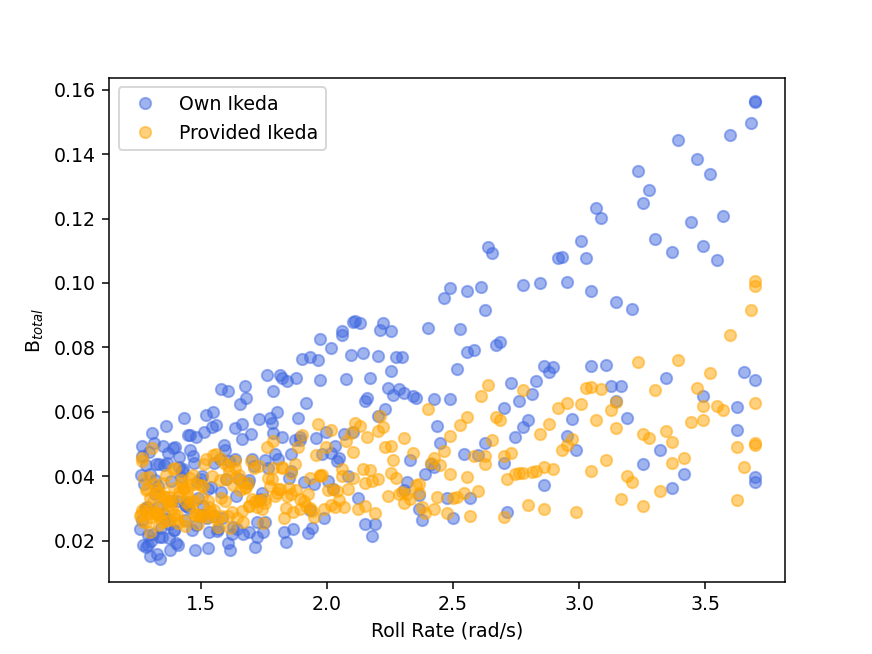

<function matplotlib.pyplot.show(*args, **kw)>

In [83]:
file_num = np.arange(0,305,1)

df_B_given = []

for x in file_num:

    data_timetrace = pd.read_csv(data_folder/"data_MARIN_CFD/timeTraces/withFreeSurface_{}.csv".format(x))
    time = data_timetrace['t']
    theta = (data_timetrace['rollAngle'])
    theta_rep =(max(theta))
    RollDampMom= data_timetrace['Mzz_fitted_damping']
    Test_case = data_period['case']
    
    data_period = pd.read_csv(data_folder/"data_MARIN_CFD/allData_withFreeSurface.csv".format(x))
    T_column = data_period['period']
    T = T_column[x]
    omega_rep = 2*np.pi/T
    
    data_ikeda = pd.read_csv(data_folder/"data_MARIN_CFD/allData_Ikeda.csv".format(x))
    b_given = data_ikeda['b*']
    
    numpy_array = ([theta_rep,omega_rep,b_given[x]])
    df_B_given.append(numpy_array)
    
df_B_given = pd.DataFrame(df_B_given, columns = ('theta','omega','B_given'))

B_total_ikeda1 = (np.asarray((df_Bbk_ikeda['B_bk ikeda']))+np.asarray((df_BE_ikeda ['B_E ikeda']))+B_W_hat)

plt.figure()
plt.plot(df_B_given['omega'], B_total_ikeda1,'o', color = 'royalblue', alpha = 0.5, label = 'Own Ikeda')
plt.plot(df_B_given['omega'],df_B_given['B_given'],'o', color = 'orange',  alpha = 0.5, label = 'Provided Ikeda')
plt.ylabel('B$_{total}$')
plt.xlabel('Roll Rate (rad/s)')
plt.legend()
plt.show



## Linear Machine Learning Methods

In [85]:
test_B_E = sorted(pd.Series.tolist(test_set.copy()))

file_num_test = np.arange(0,len(test_set),1)

list_theta_test = []
list_KL_test = []
list_KA_test = []
list_CoG_test = []
list_ikeda_test = []

for i in file_num_test:
    index_no = list_B_E.index(test_B_E[i])
    test_theta = (list_theta_rep[index_no])
    test_KL = (list_KL[index_no])
    test_KA = (list_KA[index_no])
    test_CoG = (list_CoG[index_no])
    test_ikeda = (B_visc_ikeda[index_no])
    
    list_theta_test.append(test_theta)
    list_KL_test.append(test_KL)
    list_KA_test.append(test_KA)
    list_CoG_test.append(test_CoG)
    list_ikeda_test.append(test_ikeda)
    
test_theta = np.array(list_theta_test)
test_KL = np.array(list_KL_test)
test_KA = np.array(list_KA_test)
test_CoG = np.array(list_CoG_test)
test_ikeda = np.array(list_ikeda_test)

df_test = []
for i in file_num_test:
    numpy_array = ([test_theta[i],test_B_E[i],test_KL[i],test_KA[i],test_CoG[i],test_ikeda[i] ])
    df_test.append(numpy_array)
    
df_test = pd.DataFrame(df_test, columns = ('theta','B_E','Keel Length', 'Keel Angle','CoG','ikeda'))

### Simple Linear Regression

#### Using Theta

In [26]:
nPolyFeatures = 2
poly_model = make_pipeline(StandardScaler(),
                               PolynomialFeatures(nPolyFeatures),
                               LinearRegression())

X = df_BE[["theta"]].values

y = df_BE["B_E_CFD"].values
poly_model.fit(X, y)
result = poly_model.predict(X)
score_all = explained_variance_score(y, result)

models = {"Linear regression": make_pipeline(StandardScaler(), PolynomialFeatures(nPolyFeatures), LinearRegression()),}

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.2, random_state=42)

predictor_lin = LinearRegression(n_jobs=-1)
predictor_lin.fit(X_train, y_train)
outcome_lin_1vars = predictor_lin.predict(X=X_test)
outcome_lin_1var= predictor_lin.predict(X=X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_lin_1vars[i]<0:
        outcome_lin_1var[i] = 0
    else:
        outcome_lin_1var[i] =outcome_lin_1vars[i]

theta_test = X_test[:,[0]]


#### Using Theta and Keel Length

In [27]:
nPolyFeatures = 2
poly_model = make_pipeline(StandardScaler(),
                               PolynomialFeatures(nPolyFeatures),
                               LinearRegression())

X = df_BE[["theta","Keel Length"]].values

y = df_BE["B_E_CFD"].values
poly_model.fit(X, y)
result = poly_model.predict(X)
score_all = explained_variance_score(y, result)
    
models = {"Linear regression": make_pipeline(StandardScaler(), PolynomialFeatures(nPolyFeatures), LinearRegression()),}

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.2, random_state=42)

predictor_lin = LinearRegression(n_jobs=-1)
predictor_lin.fit(X_train, y_train)
outcome_lin_2vars = predictor_lin.predict(X=X_test)
outcome_lin_2var = predictor_lin.predict(X=X_test)


n = len(y_test)

for i in range (0,n):
    if outcome_lin_2vars[i]<0:
        outcome_lin_2var[i] = 0
    else:
        outcome_lin_2var[i] =outcome_lin_2vars[i]

#### Using Theta, Keel Length and Keel Angle

In [28]:
nPolyFeatures = 2
poly_model = make_pipeline(StandardScaler(),
                               PolynomialFeatures(nPolyFeatures),
                               LinearRegression())

X = df_BE[["theta","Keel Length", "Keel Angle"]].values

y = df_BE["B_E_CFD"].values
poly_model.fit(X, y)
result = poly_model.predict(X)
score_all = explained_variance_score(y, result)
    
models = {"Linear regression": make_pipeline(StandardScaler(), PolynomialFeatures(nPolyFeatures), LinearRegression()),}

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.2, random_state=42)

predictor_lin = LinearRegression(n_jobs=-1)
predictor_lin.fit(X_train, y_train)
outcome_lin_3vars = predictor_lin.predict(X=X_test)
outcome_lin_3var = predictor_lin.predict(X=X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_lin_3vars[i]<0:
        outcome_lin_3var[i] = 0
    else:
        outcome_lin_3var[i] =outcome_lin_3vars[i]

#### Using Theta, Keel Length, Keel Angle and CoG

In [33]:
nPolyFeatures = 2
poly_model = make_pipeline(StandardScaler(),
                               PolynomialFeatures(nPolyFeatures),
                               LinearRegression())

X = df_BE[["theta","Keel Length", "Keel Angle","CoG"]].values

y = df_BE["B_E_CFD"].values
poly_model.fit(X, y)
result = poly_model.predict(X)
score_all = explained_variance_score(y, result)
    
models = {"Linear regression": make_pipeline(StandardScaler(), PolynomialFeatures(nPolyFeatures), LinearRegression()),
         "Ridge regression": make_pipeline(StandardScaler(), PolynomialFeatures(nPolyFeatures), Ridge()),}

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.2, random_state=42)
X_test2, X_train2, y_test2, y_train2 = train_test_split(X, y, train_size=0.2, random_state=10)
X_test3, X_train3, y_test3, y_train3 = train_test_split(X, y, train_size=0.2, random_state=70)

predictor_lin = LinearRegression(n_jobs=-1)
predictor_lin.fit(X_train, y_train)
outcome_lin_4vars = predictor_lin.predict(X=X_test)
outcome_lin_4var = predictor_lin.predict(X=X_test)

predictor_lin2 = LinearRegression(n_jobs=-1)
predictor_lin2.fit(X_train2, y_train2)
outcome_lin_4vars2 = predictor_lin2.predict(X=X_test)
outcome_lin_4var2 = predictor_lin2.predict(X=X_test)

predictor_lin3 = LinearRegression(n_jobs=-1)
predictor_lin3.fit(X_train3, y_train3)
outcome_lin_4vars3 = predictor_lin3.predict(X=X_test)
outcome_lin_4var3 = predictor_lin3.predict(X=X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_lin_4vars[i]<0:
        outcome_lin_4var[i] = 0
    else:
        outcome_lin_4var[i] =outcome_lin_4vars[i]


<IPython.core.display.Javascript object>


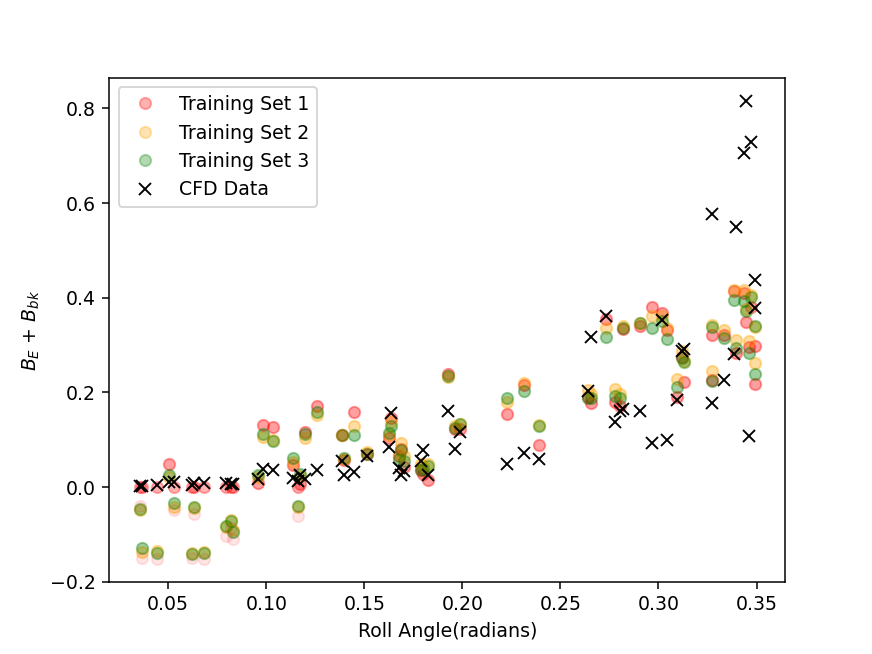

In [40]:
plt.figure()
plt.plot(theta_test,outcome_lin_4var,'o',color = 'red',alpha = 0.3, label = 'Training Set 1')
plt.plot(theta_test,outcome_lin_4var2,'o',color = 'orange',alpha = 0.3, label = 'Training Set 2')
plt.plot(theta_test,outcome_lin_4var3,'o',color = 'green',alpha = 0.3, label = 'Training Set 3')

plt.plot(theta_test,outcome_lin_4vars,'o',color = 'red',alpha = 0.1)
plt.plot(theta_test,outcome_lin_4vars2,'o',color = 'orange',alpha = 0.1)
plt.plot(theta_test,outcome_lin_4vars3,'o',color = 'green',alpha = 0.1)

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

MSE1 = mean_squared_error(y_test,outcome_lin_4var)
MSE2 = mean_squared_error(y_test,outcome_lin_4var2)
MSE3 = mean_squared_error(y_test,outcome_lin_4var3)

outcome_lin = (outcome_lin_4var+outcome_lin_4var2+outcome_lin_4var3)/3
MSE_lin = mean_squared_error(y_test,outcome_lin)

<IPython.core.display.Javascript object>


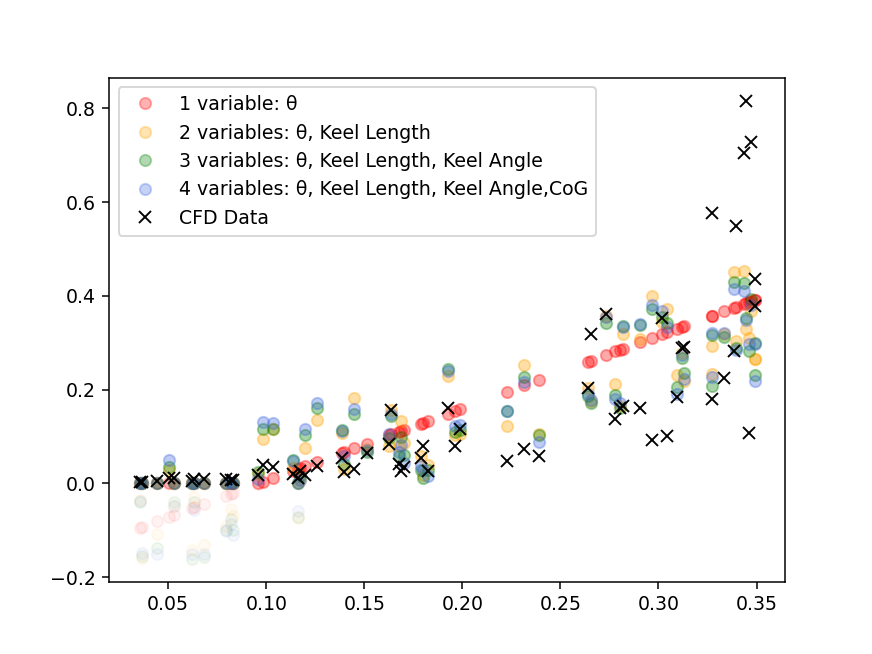

In [41]:
plt.figure()
plt.plot(theta_test,outcome_lin_1var,'o',color = 'red',alpha = 0.3, label = '1 variable: θ')
plt.plot(theta_test,outcome_lin_2var,'o',color = 'orange',alpha = 0.3, label = '2 variables: θ, Keel Length')
plt.plot(theta_test,outcome_lin_3var,'o',color = 'green',alpha = 0.3, label = '3 variables: θ, Keel Length, Keel Angle')
plt.plot(theta_test,outcome_lin_4var,'o',color = 'royalblue',alpha = 0.3, label = '4 variables: θ, Keel Length, Keel Angle,CoG')


plt.plot(theta_test,outcome_lin_1vars,'o',color = 'red',alpha = 0.05)
plt.plot(theta_test,outcome_lin_2vars,'o',color = 'orange',alpha = 0.05)
plt.plot(theta_test,outcome_lin_3vars,'o',color = 'green',alpha = 0.05)
plt.plot(theta_test,outcome_lin_4vars,'o',color = 'royalblue',alpha = 0.05)


plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

### Ridge Regression

In [42]:
alpha_value1 = 1.0
alpha_value2 = 0.5
alpha_value3 = 0.1

predictor_ridge1 = Ridge(alpha = alpha_value1)
predictor_ridge1.fit(X_train, y_train)
outcome_ridge_1 = predictor_ridge1.predict(X=X_test)
outcome_ridge_1s = predictor_ridge1.predict(X=X_test)

predictor_ridge2 = Ridge(alpha = alpha_value2)
predictor_ridge2.fit(X_train, y_train)
outcome_ridge_2 = predictor_ridge2.predict(X=X_test)
outcome_ridge_2s = predictor_ridge2.predict(X=X_test)

predictor_ridge3 = Ridge(alpha = alpha_value3)
predictor_ridge3.fit(X_train, y_train)
outcome_ridge_3 = predictor_ridge3.predict(X=X_test)
outcome_ridge_3s = predictor_ridge3.predict(X=X_test)


n = len(y_test)

for i in range (0,n):
    if outcome_ridge_1s[i]<0:
        outcome_ridge_1[i] = 0
    else:
        outcome_ridge_1[i] =outcome_ridge_1s[i]   
        
    if outcome_ridge_2s[i]<0:
        outcome_ridge_2[i] = 0
    else:
        outcome_ridge_2[i] =outcome_ridge_2s[i]  
        
    if outcome_ridge_3s[i]<0:
        outcome_ridge_3[i] = 0
    else:
        outcome_ridge_3[i] =outcome_ridge_3s[i]   
       

<IPython.core.display.Javascript object>


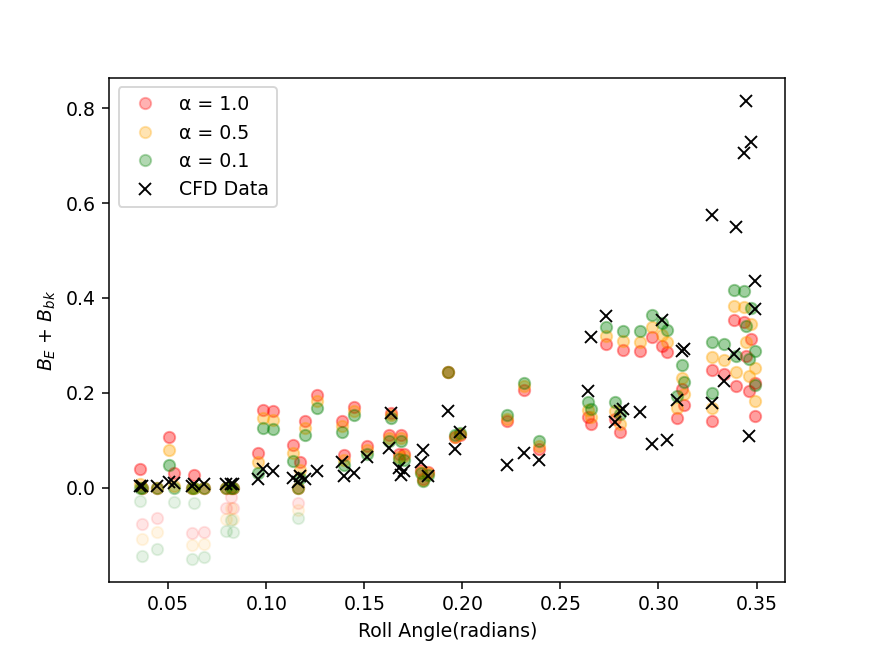

In [45]:
plt.figure()
plt.plot(theta_test,outcome_ridge_1,'o',color = 'red',alpha = 0.3, label = 'α = 1.0')
plt.plot(theta_test,outcome_ridge_2,'o',color = 'orange',alpha = 0.3, label = 'α = 0.5')
plt.plot(theta_test,outcome_ridge_3,'o',color = 'green',alpha = 0.3, label = 'α = 0.1')

plt.plot(theta_test,outcome_ridge_1s,'o',color = 'red',alpha = 0.1)
plt.plot(theta_test,outcome_ridge_2s,'o',color = 'orange',alpha = 0.1)
plt.plot(theta_test,outcome_ridge_3s,'o',color = 'green',alpha = 0.1)

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

MSE1 = mean_squared_error(y_test,outcome_ridge_1)
MSE2 = mean_squared_error(y_test,outcome_ridge_2)
MSE3 = mean_squared_error(y_test,outcome_ridge_3)

MSE_ridge = MSE3

### Comparison of Linear ML Methods

<IPython.core.display.Javascript object>


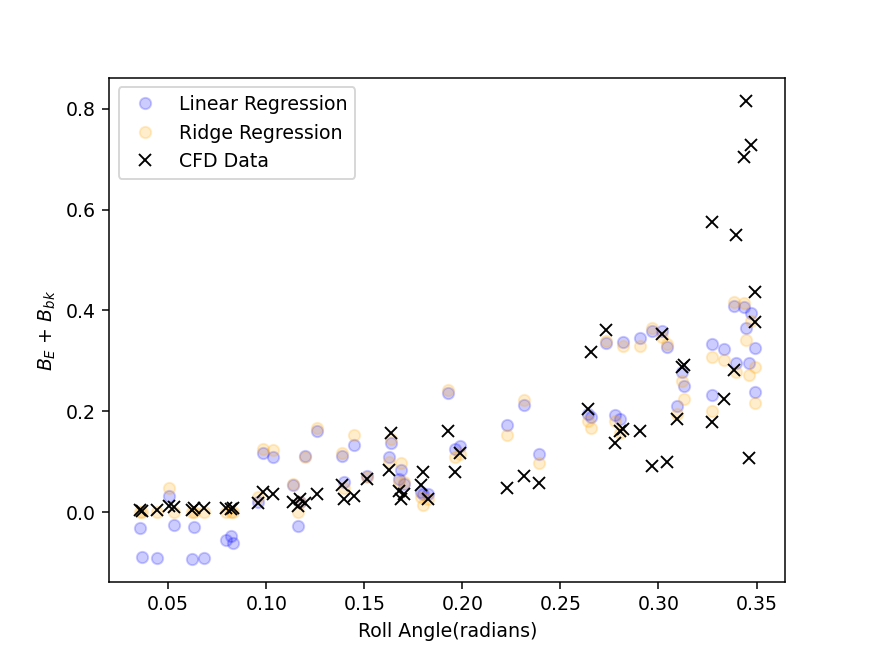

The Mean Square Error for linear regression is:  0.01624313193401616
The Mean Square Error for ridge regression is:  0.01657142538471413


In [46]:
plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

plt.figure()
plt.plot(theta_test,outcome_lin,'o',color = 'blue',alpha = 0.2, label = 'Linear Regression')
plt.plot(theta_test,outcome_ridge_3,'o',color = 'orange', alpha = 0.2, label = 'Ridge Regression')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

print ("The Mean Square Error for linear regression is: " , MSE_lin)
print ("The Mean Square Error for ridge regression is: " , MSE_ridge)

## Non-Linear Machine Learning Methods

### Support Vector Machines

In [47]:
eps = 0.15
C_value1 = 80
C_value2 = 30
C_value3 = 10

svm_poly_reg = SVR(kernel = "poly",degree = 2, C = C_value1, epsilon = eps)
svm_poly_reg.fit(X_train, y_train)
outcome_SVMs = svm_poly_reg.predict(X=X_test)
outcome_SVM = svm_poly_reg.predict(X=X_test)

svm_poly_reg2 = SVR(kernel = "poly",degree = 2, C = C_value2, epsilon = eps)
svm_poly_reg2.fit(X_train, y_train)
outcome_SVMs2 = svm_poly_reg2.predict(X=X_test)
outcome_SVM2 = svm_poly_reg2.predict(X=X_test)

svm_poly_reg3 = SVR(kernel = "poly",degree = 2, C = C_value3, epsilon = eps)
svm_poly_reg3.fit(X_train, y_train)
outcome_SVMs3 = svm_poly_reg3.predict(X=X_test)
outcome_SVM3 = svm_poly_reg3.predict(X=X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_SVMs[i]<0:
        outcome_SVM[i] = 0
    else:
        outcome_SVM[i] =outcome_SVMs[i]   
    
    if outcome_SVMs2[i]<0:
        outcome_SVM2[i] = 0
    else:
        outcome_SVM2[i] =outcome_SVMs2[i]   

    if outcome_SVMs3[i]<0:
        outcome_SVM3[i] = 0
    else:
        outcome_SVM3[i] =outcome_SVMs3[i]   

        
        
MSE1 = mean_squared_error(y_test,outcome_SVM)
MSE2 = mean_squared_error(y_test,outcome_SVM2)
MSE3 = mean_squared_error(y_test,outcome_SVM3)

<IPython.core.display.Javascript object>


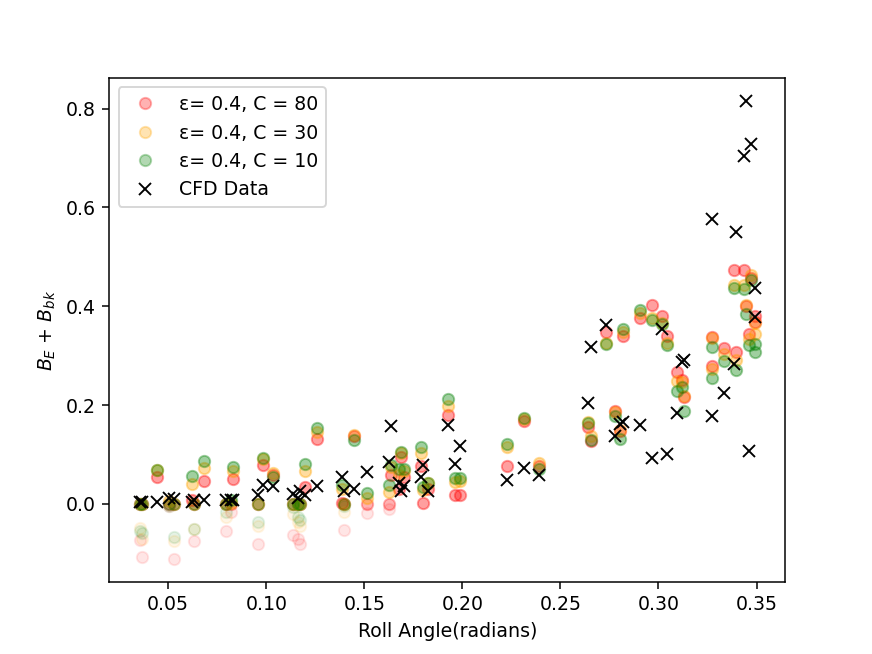

In [48]:
plt.figure()
plt.plot(theta_test,outcome_SVM,'o',color = 'red',alpha = 0.3, label = 'ε= 0.4, C = 80')
plt.plot(theta_test,outcome_SVM2,'o',color = 'orange',alpha = 0.3, label = 'ε= 0.4, C = 30')
plt.plot(theta_test,outcome_SVM3,'o',color = 'green',alpha = 0.3, label = 'ε= 0.4, C = 10')

plt.plot(theta_test,outcome_SVMs,'o',color = 'red',alpha = 0.1)
plt.plot(theta_test,outcome_SVMs2,'o',color = 'orange',alpha = 0.1)
plt.plot(theta_test,outcome_SVMs3,'o',color = 'green',alpha = 0.1)

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

### Decision Tree

In [49]:
depth_1 = None
depth_2 =1
depth_3 =5

tree_reg = DecisionTreeRegressor(max_depth = depth_1, random_state = 42)
tree_reg.fit(X_train, y_train)
outcome_DT= tree_reg.predict(X=X_test)

tree_reg2 = DecisionTreeRegressor(max_depth = depth_2, random_state = 42)
tree_reg2.fit(X_train, y_train)
outcome_DT2= tree_reg2.predict(X=X_test)

tree_reg3 = DecisionTreeRegressor(max_depth = depth_3, random_state = 42)
tree_reg3.fit(X_train, y_train)
outcome_DT3= tree_reg3.predict(X=X_test)


MSE1 = mean_squared_error(y_test,outcome_DT)
MSE2 = mean_squared_error(y_test,outcome_DT2)
MSE3 = mean_squared_error(y_test,outcome_DT3)

<IPython.core.display.Javascript object>


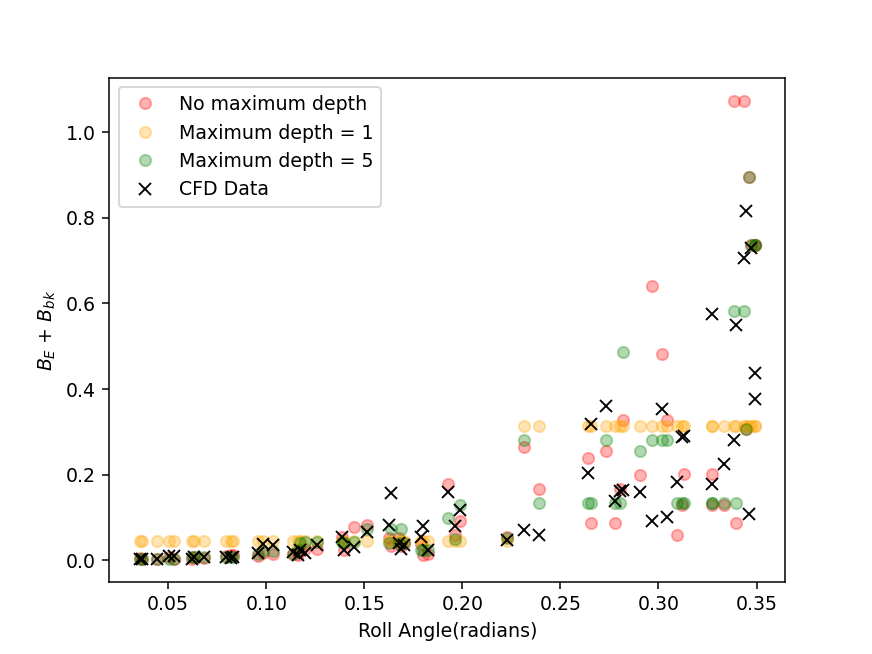

In [50]:
plt.figure()
plt.plot(theta_test,outcome_DT,'o',color = 'red',alpha = 0.3, label = 'No maximum depth')
plt.plot(theta_test,outcome_DT2,'o',color = 'orange',alpha = 0.3, label = 'Maximum depth = 1')
plt.plot(theta_test,outcome_DT3,'o',color = 'green',alpha = 0.3, label = 'Maximum depth = 5')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

### Gradient Boosted Decision Tree

In [51]:
l_r1 = 1
l_r2 = 0.7
l_r3 = 0.3

gbrt = GradientBoostingRegressor(max_depth = 1, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X_train, y_train)
outcome_GBRTs = gbrt.predict(X=X_test)
outcome_GBRT = gbrt.predict(X=X_test)

gbrt2 = GradientBoostingRegressor(max_depth = 1, n_estimators = 3, learning_rate = 0.9)
gbrt2.fit(X_train, y_train)
outcome_GBRT2 = gbrt2.predict(X=X_test)
outcome_GBRT2s = gbrt.predict(X=X_test)

gbrt3 = GradientBoostingRegressor(max_depth = 1, n_estimators = 3, learning_rate = 0.8)
gbrt3.fit(X_train, y_train)
outcome_GBRT3 = gbrt3.predict(X=X_test)
outcome_GBRT3s = gbrt3.predict(X=X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_GBRTs[i]<0:
        outcome_GBRT[i] = 0
    else:
        outcome_GBRT[i] =outcome_GBRTs[i]  
        
    if outcome_GBRT2s[i]<0:
        outcome_GBRT2[i] = 0
    else:
        outcome_GBRT2[i] =outcome_GBRT2s[i]  
                
    if outcome_GBRT3s[i]<0:
        outcome_GBRT3[i] = 0
    else:
        outcome_GBRT3[i] =outcome_GBRT3s[i]  

MSE1 = mean_squared_error(y_test,outcome_GBRT)
MSE2 = mean_squared_error(y_test,outcome_GBRT2)
MSE3 = mean_squared_error(y_test,outcome_GBRT3)

<IPython.core.display.Javascript object>


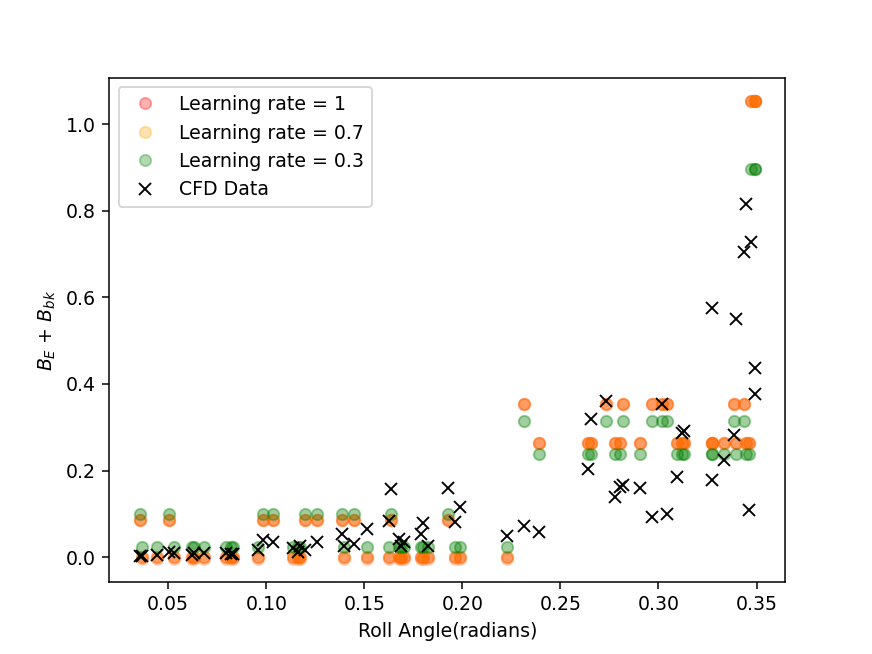

In [52]:
plt.figure()
plt.plot(theta_test,outcome_GBRT,'o',color = 'red',alpha = 0.3, label = 'Learning rate = 1')
plt.plot(theta_test,outcome_GBRT2,'o',color = 'orange',alpha = 0.3, label = 'Learning rate = 0.7')
plt.plot(theta_test,outcome_GBRT3,'o',color = 'green',alpha = 0.3, label = 'Learning rate = 0.3')

plt.plot(theta_test,outcome_GBRTs,'o',color = 'red',alpha = 0.1)
plt.plot(theta_test,outcome_GBRT2s,'o',color = 'orange',alpha = 0.1)
plt.plot(theta_test,outcome_GBRT3s,'o',color = 'green',alpha = 0.1)

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

## Comparison of Non Linear Methods

<IPython.core.display.Javascript object>


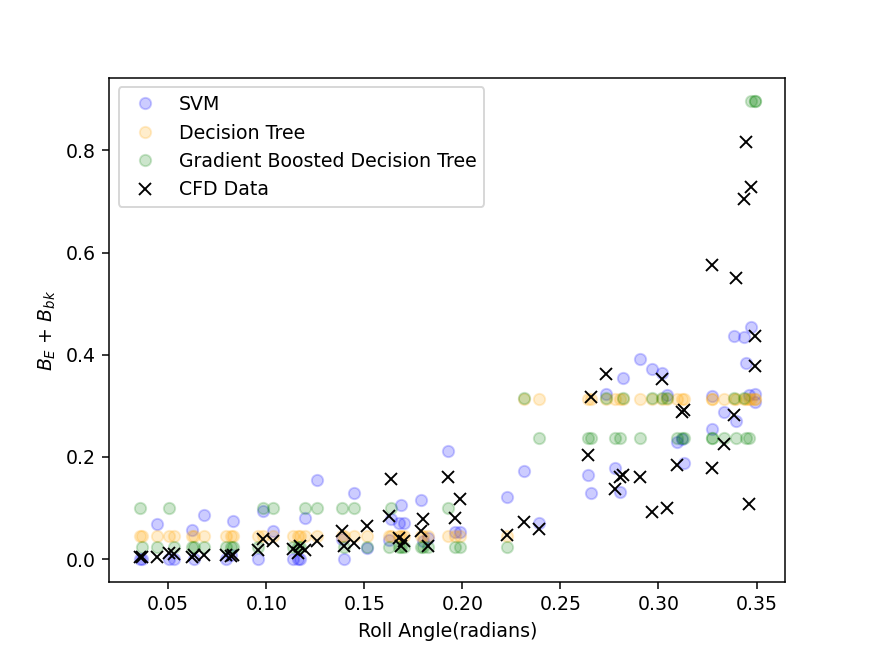

In [53]:
plt.figure()
plt.plot(theta_test,outcome_SVM3,'o',color = 'blue',alpha = 0.2, label = 'SVM')
plt.plot(theta_test,outcome_DT2,'o',color = 'orange', alpha = 0.2, label = 'Decision Tree')
plt.plot(theta_test,outcome_GBRT3,'o',color = 'green', alpha = 0.2, label = 'Gradient Boosted Decision Tree')

#plt.plot(theta_test,outcome_SVMs,'o',color = 'red',alpha = 0.1)

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')
plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()


## Neural Networks

### Quasi-Newton Method

In [54]:
regr_lbfgs = MLPRegressor(solver ='lbfgs', max_iter=10000).fit(X_train, y_train)
outcome_lbfgs_1 = regr_lbfgs.predict(X_test)
outcome_lbfgs = regr_lbfgs.predict(X_test)

regr_lbfgs2 = MLPRegressor(solver ='lbfgs', max_iter=20000).fit(X_train2, y_train2)
outcome_lbfgs_2 = regr_lbfgs2.predict(X_test)
outcome_lbfgs2 = regr_lbfgs2.predict(X_test)

regr_lbfgs3 = MLPRegressor(solver ='lbfgs', max_iter=20000).fit(X_train3, y_train3)
outcome_lbfgs_3 = regr_lbfgs3.predict(X_test)
outcome_lbfgs3 = regr_lbfgs3.predict(X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_lbfgs_1[i]<0:
        outcome_lbfgs[i] = 0
    else:
        outcome_lbfgs[i] =outcome_lbfgs_1[i]

    if outcome_lbfgs_2[i]<0:
        outcome_lbfgs2[i] = 0
    else:
        outcome_lbfgs2[i] =outcome_lbfgs_2[i]        

    if outcome_lbfgs_3[i]<0:
        outcome_lbfgs3[i] = 0
    else:
        outcome_lbfgs3[i] = outcome_lbfgs_3[i]         
        
outcome_lbfgs_final = (outcome_lbfgs+outcome_lbfgs2+outcome_lbfgs3)/3
        
MSE_lbfgs_final = mean_squared_error(y_test,outcome_lbfgs_final)
MSE_lbfgs = mean_squared_error(y_test,outcome_lbfgs)
MSE_lbfgs2 = mean_squared_error(y_test,outcome_lbfgs2)
MSE_lbfgs3 = mean_squared_error(y_test,outcome_lbfgs3)

<IPython.core.display.Javascript object>


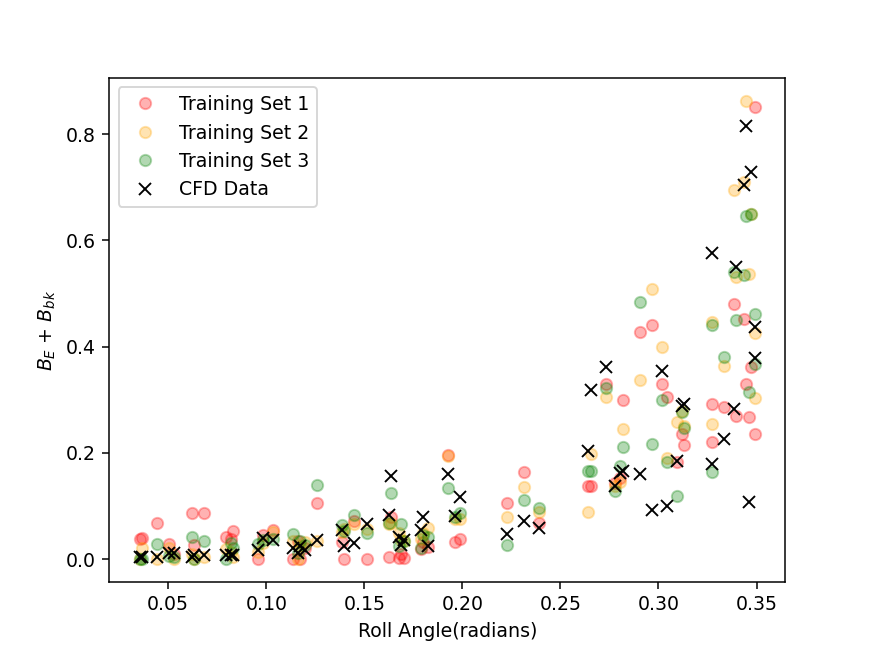

In [55]:
plt.figure()
plt.plot(theta_test,outcome_lbfgs,'o',color = 'red', alpha = 0.3, label = 'Training Set 1')
plt.plot(theta_test,outcome_lbfgs2,'o',color = 'orange', alpha = 0.3, label = 'Training Set 2')
plt.plot(theta_test,outcome_lbfgs3,'o',color = 'green', alpha = 0.3, label = 'Training Set 3')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')

plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

### Stochastic Gradient Descent

In [56]:
regr_sgd = MLPRegressor(solver ='sgd', max_iter=1000).fit(X_train, y_train)
outcome_sgd_1 = regr_sgd.predict(X_test)
outcome_sgd = regr_sgd.predict(X_test)

regr_sgd2 = MLPRegressor(solver ='sgd', max_iter=1000).fit(X_train2, y_train2)
outcome_sgd_2 = regr_sgd.predict(X_test)
outcome_sgd2 = regr_sgd.predict(X_test)

regr_sgd3 = MLPRegressor(solver ='sgd', max_iter=1000).fit(X_train3, y_train3)
outcome_sgd_3 = regr_sgd3.predict(X_test)
outcome_sgd3 = regr_sgd3.predict(X_test)

n = len(y_test)

for i in range (0,n):
    if outcome_sgd_1[i]<0:
        outcome_sgd[i] = 0
    else:
        outcome_sgd[i] =outcome_sgd_1[i] 
        
    if outcome_sgd_2[i]<0:
        outcome_sgd2[i] = 0
    else:
        outcome_sgd2[i] =outcome_sgd_2[i]
        
    if outcome_sgd_3[i]<0:
        outcome_sgd3[i] = 0
    else:
        outcome_sgd3[i] =outcome_sgd_3[i]   
        
outcome_sgd_final = (outcome_sgd + outcome_sgd2 + outcome_sgd3)/3
        
MSE_sgd_final = mean_squared_error(y_test,outcome_sgd_final)
MSE_sgd = mean_squared_error(y_test,outcome_sgd)
MSE_sgd2 = mean_squared_error(y_test,outcome_sgd2)
MSE_sgd3 = mean_squared_error(y_test,outcome_sgd3)


<IPython.core.display.Javascript object>


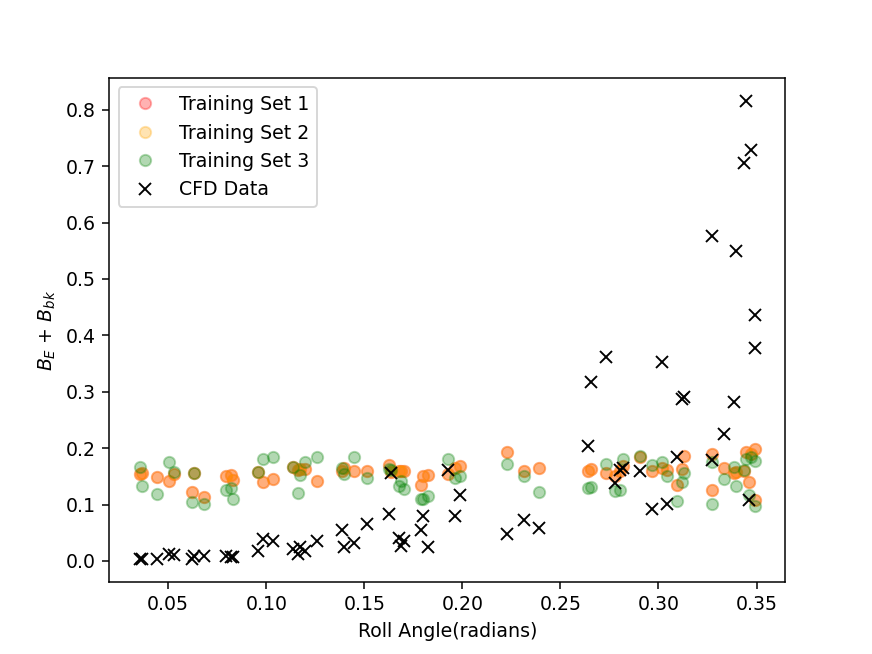

In [57]:
plt.figure()
plt.plot(theta_test,outcome_sgd,'o',color = 'red', alpha = 0.3, label = 'Training Set 1')
plt.plot(theta_test,outcome_sgd2,'o',color = 'orange', alpha = 0.3, label = 'Training Set 2')
plt.plot(theta_test,outcome_sgd3,'o',color = 'green', alpha = 0.3, label = 'Training Set 3')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')

plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

## Comparison of Neural Network Methods

<IPython.core.display.Javascript object>


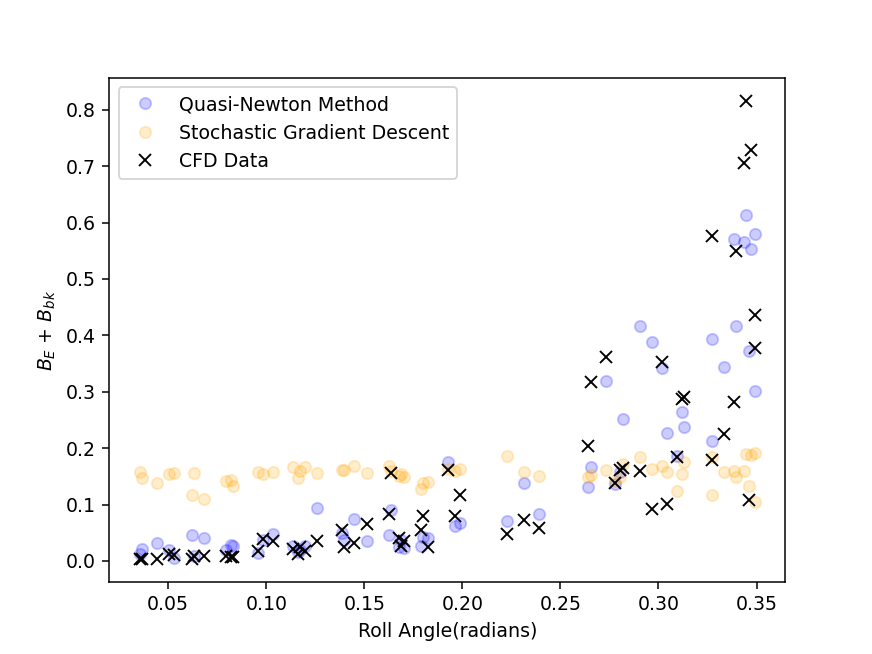

The Mean Square Error for the quasi-newton method is:  0.009443357635573205
The Mean Square Error for the stochastic gradient descent is:  0.03466909803743022


In [58]:
plt.figure()
plt.plot(theta_test,outcome_lbfgs_final,'o',color = 'blue', alpha = 0.2, label = 'Quasi-Newton Method')
plt.plot(theta_test,outcome_sgd_final,'o',color = 'orange', alpha = 0.2, label = 'Stochastic Gradient Descent')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD Data')

plt.legend()

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()


print ("The Mean Square Error for the quasi-newton method is: " , MSE_lbfgs_final)
print ("The Mean Square Error for the stochastic gradient descent is: " , MSE_sgd_final)

## Comparison of CFD, Machine Learning and Ikeda Calculations

<IPython.core.display.Javascript object>


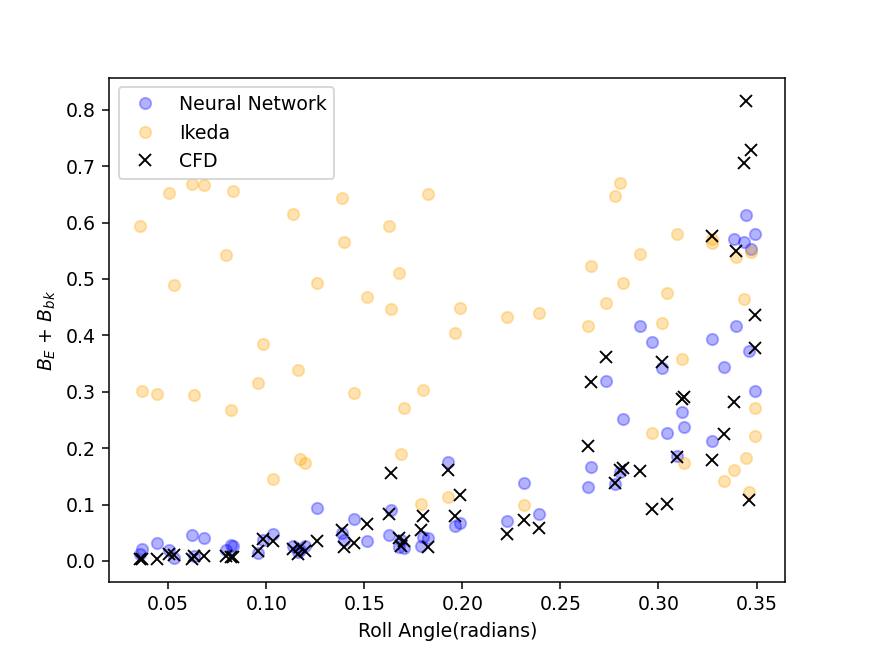

In [86]:
plt.figure()
plt.plot(theta_test,outcome_lbfgs_final,'o',color = 'blue', alpha = 0.3, label = 'Neural Network')
plt.plot(theta_test,df_test['ikeda'],'o',color = 'orange', alpha = 0.3, label = 'Ikeda')

plt.plot(theta_test,y_test,'x',color = 'black', label = 'CFD')

plt.legend(loc = "upper left")

plt.ylabel('$B_E$ + $B_{bk}$')
plt.xlabel('Roll Angle(radians)')
plt.show()

# Design Comparison

In [87]:
t = np.array(np.linspace(0,17.5,1800))

T_assumed_1 = 4.2674
theta0_1 =   0.1687384320828118
KL_1 =   0.606
KA_1 =  0.998
yCG_1 = -0.0454597

T_assumed_2 = 3.647
theta0_2 = 0.2076941809873252
KL_2 =  0.15000000000000002
KA_2 = 0.99
yCG_2 =  -0.0335665

f1 = 1/T_assumed_1
f2 = 1/T_assumed_2

omega_1 = np.sin((f1*2*np.pi*(t)))
omega_2 = np.sin((f2*2*np.pi*(t)))

X_compare = [theta0_1,KL_1,KA_1,yCG_1],[theta0_2,KL_2,KA_2,yCG_2]

B_visc = (regr_lbfgs.predict(X_compare)+regr_lbfgs2.predict(X_compare)+regr_lbfgs3.predict(X_compare))/3
B_v1 = B_visc[0]
B_2_1 = B_v1/(max(omega_1)*theta0_1)

B_v2 = B_visc[-1]
B_2_2 = B_v2/(max(omega_2)*theta0_2)

M_v1_amp = B_2_1*(omega_1*abs(omega_1))
M_v1_max = max(M_v1_amp)
M_v1 = omega_1 * M_v1_max

M_v2_amp = B_2_2*(omega_2*abs(omega_2))
M_v2_max = max(M_v2_amp)
M_v2 = omega_2 * M_v2_max



<IPython.core.display.Javascript object>


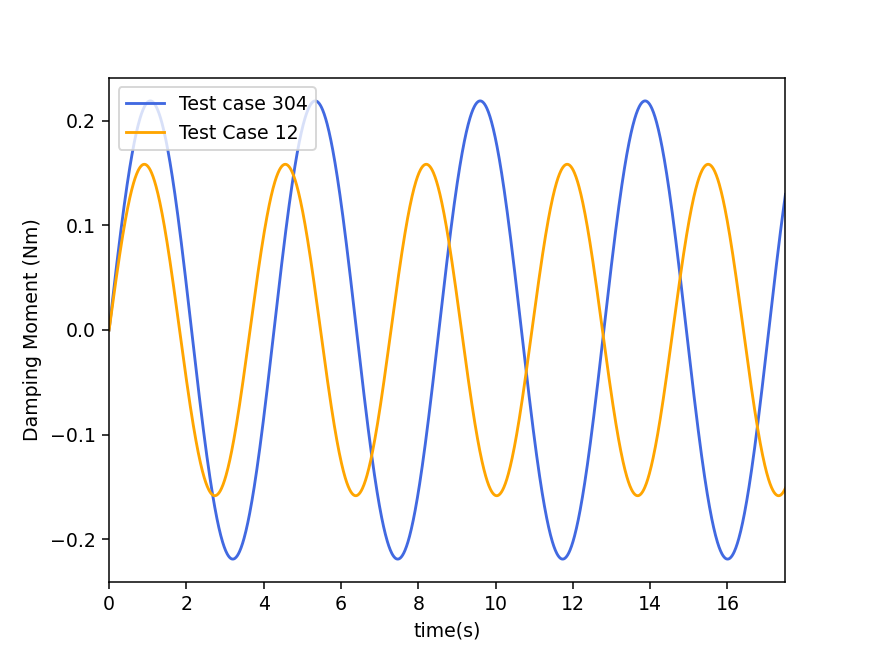

In [88]:
plt.figure()

plt.plot(t,M_v1, label = "Test case 304",color = "royalblue")
plt.plot(t,M_v2, label = "Test Case 12",color = "orange")

plt.xlabel("time(s)")
plt.xlim(0,17.5)
plt.ylabel("Damping Moment (Nm)")
plt.legend(loc = "upper left")